In [1]:
import boto3
import json
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Activation, Dense
from keras.callbacks import EarlyStopping

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import random
import math

import lightgbm
import numpy as np

from scipy import stats

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Pull data from DynamoDB

In [2]:
dynamo = boto3.client('dynamodb')

data = dynamo.scan(
    TableName = 'CoinApi-SimpleTable-1G0W6OP20001J'
)['Items']

In [3]:
def format_data(dat):
    try:
        return  json.loads(dat['S'])
    except:
        return None


parsed_data = []

for d in data:
    parsed_data += list(d.values())
    
parsed_data = [format_data(pd) for pd in parsed_data]
parsed_data = pd.DataFrame([pd for pd in parsed_data if pd is not None]).drop(['time_period_start', 'time_period_end', 'time_open'], axis=1)
parsed_data['time_close'] = [pd.split('T')[0] for pd in parsed_data['time_close'].tolist()]

In [4]:
parsed_data = parsed_data.sort_values('time_close')
parsed_data.head()

time_close   price_open   price_high   price_low  price_close  \
1123  2018-10-21     0.454210      0.47809     0.45034     0.453000   
1121  2018-10-21   202.330000    321.12000   176.00000   207.290000   
1120  2018-10-21  6409.350000  15606.37000  2709.45000  6415.880000   
1122  2018-10-21     0.004787      0.00600     0.00435     0.004672   
392   2018-10-22  6405.810000   8700.00000  5702.94000  6407.650000   

      volume_traded  trades_count  coin  
1123   2.989105e+07         15807   XRP  
1121   1.818250e+05         45320   ETH  
1120   5.632258e+05         89146   BTC  
1122   1.254736e+07           911  DOGE  
392    5.500308e+05        116661   BTC

## Comparing Closing Prices Across Currencies

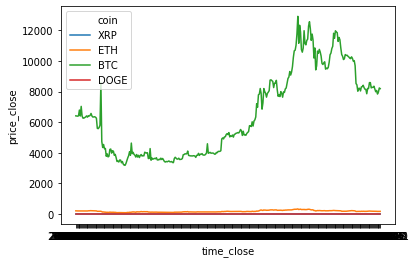

In [5]:
viz_data = parsed_data

sns.lineplot(
    x = 'time_close',
    y = 'price_close',
    hue = 'coin',
    data=viz_data
)

This graphic doesn't tell us much, other than bitcoin closes much higher than all of the other currencies. Below we log scale the closing price to get a better view

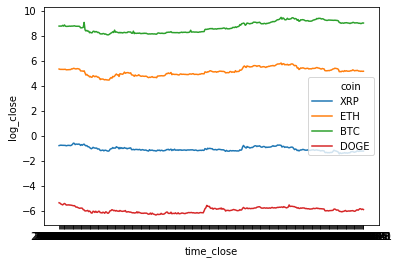

In [6]:
viz_data['log_close'] = [math.log(price) for price in viz_data['price_close'].tolist()]

sns.lineplot(
    x = 'time_close',
    y = 'log_close',
    hue = 'coin',
    data=viz_data
)

This is better. We can see that Bitcoin is consistently pricier. I don't think we'd need to do any more rigorous statistical testing to tell us this. But what matters to us if we want to invest in a currency is simple: How much money will it make proportional to what I invest, and how risky is the investment?

To measure risk, we can look at how much it swings in a single day from its highest point to its lowest point. Let's look at this intraday swing across the currencies.

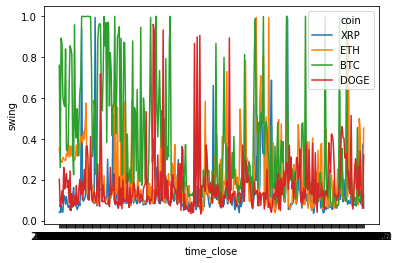

In [7]:
viz_data['swing'] = (viz_data['price_high'] - viz_data['price_low']) / (viz_data['price_high'] + viz_data['price_low'] / 2)
sns.lineplot(
    x = 'time_close',
    y = 'swing',
    hue = 'coin',
    data=viz_data
)

This really doesn't tell us much. We need to examine these numbers a bit further. I would prefer to do a Bayesian t-test, but for now, we will do a normal t-test. This has some issues since doing a simple, two-sample t-test on multiple samples runs into multiple hypothesis problems. But, I don't think we are going to be using these numbers as hard statistical evidence, merely just to motivate further questions.

In [8]:
btc_swing = viz_data[viz_data['coin'] == 'BTC']['swing']
eth_swing = viz_data[viz_data['coin'] == 'ETH']['swing']
xrp_swing = viz_data[viz_data['coin'] == 'XRP']['swing']
doge_swing = viz_data[viz_data['coin'] == 'DOGE']['swing']

print(f'mean BTC swing: {np.mean(btc_swing)}')
print(f'mean ETH swing: {np.mean(eth_swing)}')
print(f'mean XRP swing: {np.mean(xrp_swing)}')
print(f'mean DOGE swing: {np.mean(doge_swing)}')

mean BTC swing: 0.368217221056056
mean ETH swing: 0.21236750311473704
mean XRP swing: 0.13859846960663613
mean DOGE swing: 0.17822745018727376


In [9]:
## Is BTC really more volatile than everyone else?

print(stats.ttest_ind(btc_swing, eth_swing))
print(stats.ttest_ind(btc_swing, xrp_swing))
print(stats.ttest_ind(btc_swing, doge_swing))

Ttest_indResult(statistic=8.656968171577017, pvalue=3.497157455359008e-17)
Ttest_indResult(statistic=13.409300675449767, pvalue=1.5109173429591914e-36)
Ttest_indResult(statistic=10.930007567120278, pvalue=9.907324958009364e-26)


Again, I'm not a fan of p-values, and would prefer to set up a more careful Bayesian approach if we were going to put a significant amount of money into this, but for now, I think it's reasonable to operate under the beliefthat Bitcoin is the most volatile of the group. Of course, this volatilty in itself is not necessarily a bad thing, or at least, we could say that the lack of volatility is not necessarily a good thing. Bitcoin is volatile, in part because of its much higher volume of trades.

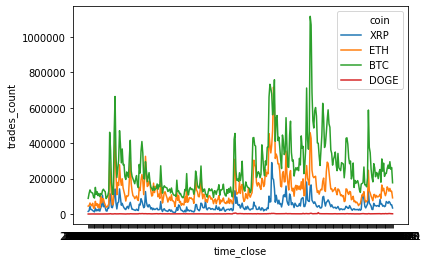

In [10]:
sns.lineplot(
    x = 'time_close',
    y = 'trades_count',
    hue = 'coin',
    data=viz_data
)

This visual has a symmetry to the closing price one above. It shouldn't be a surprise, given Bitcoin's popularity, that it would see more trades in a day, and more trades, really by definition, means the price fluctuates more. So, then what do we really care about when we look at this data? If we were going to get into the cryptocurrency game for the long term, we'd probably build a lot of models and a lot of visuals, come up with a lot of hypotheses and even more tests. But for now, we're just trying to get a lay of the land. We want to start trading and we need a place to start. I'd say, for our first day of trading, all we really care about is, if we had to buy one currency that would show the best result. What we need to do is build a prediction model that will tell us which of these currencies will give us the best return in the short term (for now a single day, we can get more sophisticated once we've been in the market for a few weeks).

## Building a Prediction Model


I am going to try to build a few simple prediction models to motivate next steps. First I'm going to try lightgbm and random forest models. These are both good tree-based classifiers.



## Data Preparation

The nice thing about these two models is that, since they are deciding on how to split binary trees based on some measure of entropy, they are not subject to the same sorts of numerical problems that can hound more traditional, linear algebra-based models (the exploding/vanishing gradient problem in neural networks is a good example. Repeated multiplication of very small numbers causes gradients to become numerically zero). Because of this, we aren't going to do a whole lot in terms of data cleanup.

First I am going to spread the data so that the feature set is wider and has a column for each of the currencies. Then I am going to sort in ascending order of the closing date, then drop any non-numerical columns, or map them to numbers.

In [11]:
btc = parsed_data[parsed_data['coin'] == 'BTC'].drop('coin', axis=1)
etherium = parsed_data[parsed_data['coin'] == 'ETH'].drop('coin', axis=1)
ripple = parsed_data[parsed_data['coin'] == 'XRP'].drop('coin', axis=1)
dogecoin = parsed_data[parsed_data['coin'] == 'DOGE'].drop('coin', axis=1)

btc_eth = btc.merge(etherium, on='time_close', suffixes=['_btc', '_eth'])
ripple_doge = ripple.merge(dogecoin, on='time_close', suffixes=['_xrp', '_doge'])

data = btc_eth.merge(ripple_doge, on='time_close')

## Currency performance trends - single day

First, let's calculate what this metric is for the data we have.

In [12]:
def percentage_gain(row):
    return {
        'time_close': row['time_close'],
        'coin': row['coin'],
        'gain': (row['price_close'] - row['price_open']) / row['price_open']
    }

gains = pd.DataFrame([percentage_gain(d) for d in json.loads(parsed_data.to_json(orient='records'))])

gains = gains.sort_values(['time_close', 'gain'], ascending=[True, False]).drop_duplicates(subset=['time_close'])

In [13]:
data = data.merge(gains.drop('gain', axis=1), on='time_close').sort_values('time_close')

In [14]:
## offset dates by one day
data['coin'] = [None] + data['coin'].tolist()[:-1]
data = data.drop(data.index[0])

In [15]:
def remap(label):
    mapping = {
        'BTC': 0,
        'ETH': 1,
        'XRP': 2,
        'DOGE': 3
    }
    try:
        return mapping[label]
    except:
        return label

In [16]:
features = data.drop(['coin', 'time_close'], axis=1)
labels = data['coin']

labels = [remap(label) for label in labels]


random.seed(321)
features_train, features_test, labels_train, labels_test = train_test_split(
    features,
    labels,
    test_size = .4
)

train = lightgbm.Dataset(features_train, labels_train)
eval_ = lightgbm.Dataset(features_test, labels_test, reference=train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'softmax',
    'num_leaves': 31,
    'num_class': 4,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 10
}

print('Starting training...')
# train
gbm = lightgbm.train(params,
                train,
                num_boost_round=100,
                valid_sets=eval_)


lightgbm.train(features, labels)

Starting training...
[1]	valid_0's multi_logloss: 1.37944
[2]	valid_0's multi_logloss: 1.37989
[3]	valid_0's multi_logloss: 1.38175
[4]	valid_0's multi_logloss: 1.38448
[5]	valid_0's multi_logloss: 1.3867
[6]	valid_0's multi_logloss: 1.38668
[7]	valid_0's multi_logloss: 1.38955
[8]	valid_0's multi_logloss: 1.39407
[9]	valid_0's multi_logloss: 1.39735
[10]	valid_0's multi_logloss: 1.39958
[11]	valid_0's multi_logloss: 1.39956
[12]	valid_0's multi_logloss: 1.40052
[13]	valid_0's multi_logloss: 1.40221
[14]	valid_0's multi_logloss: 1.40347
[15]	valid_0's multi_logloss: 1.40592
[16]	valid_0's multi_logloss: 1.40855
[17]	valid_0's multi_logloss: 1.41108
[18]	valid_0's multi_logloss: 1.41442
[19]	valid_0's multi_logloss: 1.41776
[20]	valid_0's multi_logloss: 1.41817
[21]	valid_0's multi_logloss: 1.41998
[22]	valid_0's multi_logloss: 1.42154
[23]	valid_0's multi_logloss: 1.42288
[24]	valid_0's multi_logloss: 1.42459
[25]	valid_0's multi_logloss: 1.42562
[26]	valid_0's multi_logloss: 1.42787
[

TypeError: pop() takes 2 positional arguments but 3 were given

This continues to throw an error at the last iteration, but does not seem to effect outputting a model.

In [17]:
softmax = gbm.predict(features_test, num_iteration=gbm.best_iteration)
predictions = np.array([np.argmax(pred) for pred in softmax])
sum(predictions == labels_test) / predictions.shape[0]

0.3161764705882353

We got to 31% accuracy which is not much better than chance for a 4-class problem.

In [18]:
rf = RandomForestClassifier(
    criterion = 'entropy',
    max_features = 'log2',
    max_depth = None,
    n_estimators = 1000,
    n_jobs = -1
)


rf.fit(features_train, labels_train)

predictions = rf.predict(features_test)
accuracy = accuracy_score(labels_test, predictions)

accuracy

0.34558823529411764

Again, these numbers are not much different than the lightgbm. This tells us that we are maybe about at our limit with such a simple model that doesn't take into account much sequentiality.


Next, I'm going to try to use an LSTM -- a type of neural network that works well for sequential data. We will have to engineer the dataset to conform to this architecture. This includes creating sequences of matrices that include the data for some look-back window (think of ARIMA models in time-series). Here, I'll try a 3-day window. This means that we'll have to shave some data off the beginning and end of our dataset.

Further, as mentioned above, unlike the previous models, this model will be sensitive to the fact that the numbers between columns are highly variable. For this reason, we're going to use a min-max scaler on the columns to turn our features into numbers in the range (0, 1).

In [19]:
features = data.drop(['coin', 'time_close'], axis=1)
feature_names = features.columns.values.tolist()
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

labels = pd.get_dummies(data['coin']) # one-hot encoding
label_names = labels.columns.values.tolist()
labels = labels.values[:338]

In [20]:
tensored_features = []


for i in list(range(features.shape[0])):
    time_slice = features[i:i+3]
    if time_slice.shape[0] == 3:
        tensored_features.append(time_slice)
    
features = np.stack(tensored_features)
features.shape

(338, 3, 32)

In [21]:
model = Sequential()
model.add(LSTM(64))
model.add(Dropout(.5))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    verbose=0,
    mode='auto',
    restore_best_weights=True
)


history = model.fit(
    features,
    labels,
    validation_split=.3,
    epochs=500,
    verbose=0
)

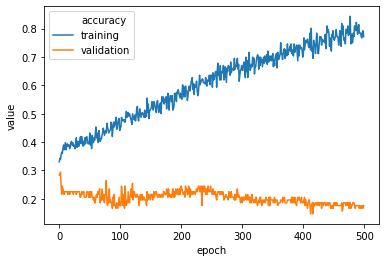

In [22]:
val_acc = pd.DataFrame({
    'epoch': list(range(0, 500)),
    'value': history.history['val_accuracy'],
    'accuracy': 'validation'
})

train_acc = pd.DataFrame({
    'epoch': list(range(0, 500)),
    'value': history.history['accuracy'],
    'accuracy': 'training'
})

accuracy = train_acc.append(val_acc)

sns.lineplot(
    x = 'epoch',
    y = 'value',
    hue = 'accuracy',
    data = accuracy
)

## Results/Next Steps

Afeter 500 epochs, the training set accuracy gets to 83%, but the validation accuracy is stuck at ~20%. This tells us that this model is certainly overfitting. But given the high accuracy on the training set, coupled with the fact that this is still a small sample (~230 observations in the training, ~100 in the validation is quite small), this might be a good algorithm that just needs to see more data. It could also be the case the architecture needs tuning; I only used a rather vanilla LSTM as proof of concept. LSTMs, and any sufficiently deep neural networks in general, are data hogs, so it could be the case that the LSTM is an algorithm worth throwing data at.

The next step would be to take one of the model outputs and put it behind an API, most likely in a lambda in the service that's already created.

In [23]:
model.save('model.h5')